In [9]:
from scienceworld import ScienceWorldEnv
import networkx as nx
import matplotlib.pyplot as plt
import re
from sources.agent.scienceworld import parse_observation
import random

# Environment exploration
- Since the agent can initiate in any location, in order to dynamically navigate through map, we create a bootstrap phase to agent explore the environment and understand the trajectory.
    - The exploration phase builds a graph where nodes are locations and edges represent the path between locations
    - After the exploration, we use a simple shortest path algorithm to dynamically *instantiate a new plan given a subgoal*


In [3]:
"""
- varrer mapa para saber onde estão os objetos
- desenvolver planos alto nivel que disparem ações como pick up thermometer, independente de onde o termometro está

- exploration (bootstrap)
    - varrer mapa entendendo localização
    - varrer mapa entendendo localização dos objetos
    - gerar planos automático baseado nessa exploração
"""
def parse(observation: str, inventory: str) -> list[str]:
    x = re.search(r"([\S\s]*?)(?:In it, you see:)([\S\s]*?)(?:You also see:)([\S\s]*)", observation)
    if x == None:
        x = re.search(r"([\S\s]*?)(?:Here you see:)([\S\s]*?)(?:You also see:)([\S\s]*)", observation)
    groups = x.groups()

    location = groups[0]
    objects = groups[1]
    doors = groups[2]

    loc_split = [location.strip()]
    obs_split = [obs.strip() for obs in objects.split('\n') if len(obs.strip()) > 0]
    obs_split = [f"You see {obs}" for obs in obs_split]
    doors_split = [door.strip() for door in doors.split('\n') if len(door.strip()) > 0]
    inventory_items = inventory.replace('\n', ' ').replace('\t', '')
    return loc_split + obs_split + doors_split + [inventory_items]

In [5]:
def get_current_location(look):
    beliefs = parse(look, "")
    current_location = beliefs[0].replace("This room is called the ", "").replace(".", "") # TODO: formulate a smart approach to get the current location
    if current_location == 'This outside location is called the outside':
        current_location = 'outside'
    return current_location

def get_next_locations(look):
    beliefs = parse(look, "")
    doors = [d for d in beliefs if d.startswith("A door to the")]
    next_locations = [d.replace("A door to the ", "").replace(" (that is closed)", "").replace(" (that is open)", "") for d in doors]
    return next_locations

#beliefs = parse(info['look'], "")
#current_location = beliefs[0].replace("This room is called the ", "").replace(".", "")
#beliefs, current_location

In [6]:
env = ScienceWorldEnv("", "", envStepLimit=100)
randVariationIdx = 0
task_name = env.getTaskNames()[0]
env.load(task_name, randVariationIdx)
env.reset()
# Run one episode until we reach a stopping condition (including exceeding the maximum steps)
action_str = "look around"  # First action
observation, reward, isCompleted, info = env.step(action_str)

graph = nx.Graph()
trajectory_idx = 1 # pointer locating the current node in the trajectory, to control the backward walking
trajectory = [] # breadcumb array
visited_nodes = []
last_loc = None

for step in range(10):
    current_location = get_current_location(info['look'])

    if current_location not in visited_nodes: # mark node as visited
        visited_nodes.append(current_location)

    available_locations = get_next_locations(info['look'])
    for location in available_locations:
        if (current_location, location) not in graph.edges:
            graph.add_edge(current_location, location)
    next_locations = [loc for loc in available_locations if loc not in visited_nodes]
    print(f"Step {step} - {current_location} -> {next_locations} - trajectory: {trajectory} - trajectory_idx: -{trajectory_idx}")

    if len(next_locations) == 0:
        # there is no new place to enter, go back to the last location and explore
        if trajectory_idx > len(trajectory): # if the backward step already reach the first trajectory node, then break
            break
        last_loc = trajectory[-trajectory_idx]
        trajectory_idx = trajectory_idx + 1
        print(f"Go back from {current_location} to {last_loc}")
        observation, reward, isCompleted, info = env.step(f"open door to {last_loc}")
        observation, reward, isCompleted, info = env.step(f"go to {last_loc}")
    else:
        if last_loc != current_location:
            trajectory.append(current_location)
        trajectory_idx = 1 # new node in the trajectory
        last_loc = current_location
        next_loc = next_locations[0]

        _ = env.step(f"open door to {next_loc}")
        observation, reward, isCompleted, info = env.step(f"go to {next_loc}")

        print(f"Visiting new location {next_loc} - {observation}")
        #TODO: trajectory array has duplicated elements (hallway)

Step 0 - hallway -> ['art studio', 'bedroom', 'greenhouse', 'kitchen', 'living room', 'workshop'] - trajectory: [] - trajectory_idx: -1
Visiting new location art studio - You move to the art studio.
Step 1 - art studio -> [] - trajectory: ['hallway'] - trajectory_idx: -1
Go back from art studio to hallway
Step 2 - hallway -> ['bedroom', 'greenhouse', 'kitchen', 'living room', 'workshop'] - trajectory: ['hallway'] - trajectory_idx: -2
Visiting new location bedroom - You move to the bedroom.
Step 3 - bedroom -> [] - trajectory: ['hallway'] - trajectory_idx: -1
Go back from bedroom to hallway
Step 4 - hallway -> ['greenhouse', 'kitchen', 'living room', 'workshop'] - trajectory: ['hallway'] - trajectory_idx: -2
Visiting new location greenhouse - You move to the greenhouse.
Step 5 - greenhouse -> ['outside'] - trajectory: ['hallway'] - trajectory_idx: -1
Visiting new location outside - You move to the outside.
Step 6 - outside -> ['foundry', 'kitchen'] - trajectory: ['hallway', 'greenhouse'

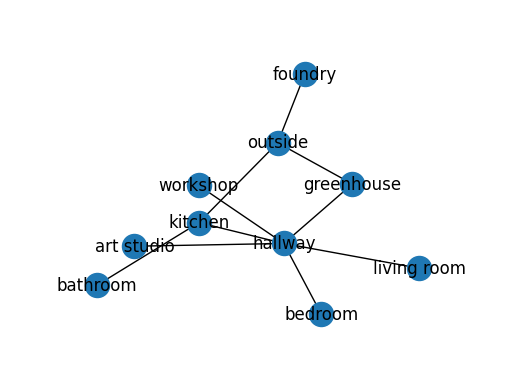

In [7]:
nx.draw_networkx(graph)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(.20)
plt.axis("off")
plt.show()

In [11]:
current = "art studio"
target = "kitchen"
path = nx.shortest_path(graph, source=current, target=target)

# move action can be considered as a custom action, similar to agent speak
print(f"Goal addition: move to {target}")
print(f"Path from {current} to {target} -> {path}")
new_plan = f"if you need to move to {target} considering you are in {current} then: {','.join([f'go to {loc}' for loc in path])}"
print(f"Plan: {new_plan}")

Goal addition: move to kitchen
Path from art studio to kitchen -> ['art studio', 'hallway', 'kitchen']
Plan: if you need to move to kitchen considering you are in art studio then: go to art studio,go to hallway,go to kitchen
